<a href="https://colab.research.google.com/github/lisabortiz/Data-Science-Portfolio/blob/main/Project_4/Spotify_Description_for_Students_v03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 4: Music Popularity Prediction


## Problem Definition
>"What's going on?"

This project will take data features collected for songs that have been on the Top 200 Weekly (Global) charts of Spotify in 2020 & 2021. The popularity of the song will be predicted using a tree-based regression model trained on these features.



The goals for the project are:

- Minimize the cross-validated ***root mean squared error ( RMSE )*** when predicting the popularity of a new song.

- Determine the importance of the features in driving the regression result.
The project will be done using tree-based regression techniques as covered in class. The hyperparameters of the trees should be carefully selected to avoid over-fitting.


There are three main challenges for this project:

1. Determining the outcome ( i.e. target ).  There is a "popularity" column.  But other columns may or may not be more appropriate indicators of popularity.

1. Choosing appropriate predictors ( i.e. features ). When building a machine learning model, we want to make sure that we consider how the model will be ultimately used. For this project, we are predicting the popularity of a new song. Therefore, we should only include the predictors we would have for a new song. It might help to imagine that the song will not be released for several weeks.

1. Data cleaning and feature engineering. Some creative cleaning and/or feature engineering may be needed to extract useful information for prediction.



Once again, be sure to go through the whole data science process and document as such in your Jupyter notebook.

The data is available AWS at https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv .



## Data Collection/Sources
>"Initial Setup"

In [ ]:
# import os
# import magic
# import random
# import duckdb
import pandas as pd
from pathlib import Path
import sqlite3 as db
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import sklearn
import numpy as np
from sklearn import datasets, metrics, model_selection
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor

### Load the data

In [ ]:
url = "https://ddc-datascience.s3.amazonaws.com/Projects/Project.4-Spotify/Data/Spotify.csv"
!curl -s -I {url}

HTTP/1.1 200 OK
x-amz-id-2: PT74rd7e7YAGE/zCH6aJ8zO43N0kecIgUnXJsnwNQSmVH7UtNRFOkJ0uFbZP7fLCNFMHGx1g4T3pHpDuyOYapREv1ZpIaiEc
x-amz-request-id: JKNGXK68FPV818EP
Date: Mon, 03 Nov 2025 05:05:49 GMT
Last-Modified: Wed, 04 Oct 2023 17:23:56 GMT
ETag: "65b9875b11e0d7ea03ee2af024f45e99"
x-amz-server-side-encryption: AES256
Accept-Ranges: bytes
Content-Type: text/csv
Content-Length: 738124
Server: AmazonS3



In [ ]:
!curl -s -O {url}

In [ ]:
ls -la

total 740
drwxr-xr-x 1 root root   4096 Nov  3 01:41 ./
drwxr-xr-x 1 root root   4096 Nov  3 01:40 ../
drwxr-xr-x 4 root root   4096 Oct 30 13:36 .config/
drwxr-xr-x 1 root root   4096 Oct 30 13:36 sample_data/
-rw-r--r-- 1 root root 738124 Nov  3 05:05 Spotify.csv


In [ ]:
!ls

sample_data  Spotify.csv


In [ ]:
!head -1 Spotify.csv | tr , '\n' | cat -n

     1	Index
     2	Highest Charting Position
     3	Number of Times Charted
     4	Week of Highest Charting
     5	Song Name
     6	Streams
     7	Artist
     8	Artist Followers
     9	Song ID
    10	Genre
    11	Release Date
    12	Weeks Charted
    13	Popularity
    14	Danceability
    15	Energy
    16	Loudness
    17	Speechiness
    18	Acousticness
    19	Liveness
    20	Tempo
    21	Duration (ms)
    22	Valence
    23	Chord


In [ ]:
#load data from CSV File
spotify_orig = pd.read_csv("Spotify.csv")
spotify_orig

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,1552,195,1,2019-12-27--2020-01-03,New Rules,"4,630,675",Dua Lipa,27167675,2ekn2ttSfGqwhhate0LSR0,"['dance pop', 'pop', 'uk pop']",...,0.762,0.7,-6.021,0.0694,0.00261,0.153,116.073,209320,0.608,A
1552,1553,196,1,2019-12-27--2020-01-03,Cheirosa - Ao Vivo,"4,623,030",Jorge & Mateus,15019109,2PWjKmjyTZeDpmOUa3a5da,"['sertanejo', 'sertanejo universitario']",...,0.528,0.87,-3.123,0.0851,0.24,0.333,152.37,181930,0.714,B
1553,1554,197,1,2019-12-27--2020-01-03,Havana (feat. Young Thug),"4,620,876",Camila Cabello,22698747,1rfofaqEpACxVEHIZBJe6W,"['dance pop', 'electropop', 'pop', 'post-teen ...",...,0.765,0.523,-4.333,0.03,0.184,0.132,104.988,217307,0.394,D
1554,1555,198,1,2019-12-27--2020-01-03,Surtada - Remix Brega Funk,"4,607,385","Dadá Boladão, Tati Zaqui, OIK",208630,5F8ffc8KWKNawllr5WsW0r,"['brega funk', 'funk carioca']",...,0.832,0.55,-7.026,0.0587,0.249,0.182,154.064,152784,0.881,F


In [ ]:
spotify_orig.isnull().sum().sum()

np.int64(0)

In [ ]:
spotify_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

### Create a copy

In [ ]:
spotify = spotify_orig.copy()

###Inspection
Now that the libraries are imported and the data set is loaded, we can verify it's import and perform an initial inspection of the data.

In the inital check, we look at a few details:


*   Head (first 5 rows)
*   Tail (Last 5 rows)
*   Info (File size, data types, rows, colums)
*   Shape (Row and Column Count)
*   Size (individual elements)

This gives a quick glance at what kind of forseeable challenges with the current data set.


In [ ]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1556 entries, 0 to 1555
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      1556 non-null   int64 
 1   Highest Charting Position  1556 non-null   int64 
 2   Number of Times Charted    1556 non-null   int64 
 3   Week of Highest Charting   1556 non-null   object
 4   Song Name                  1556 non-null   object
 5   Streams                    1556 non-null   object
 6   Artist                     1556 non-null   object
 7   Artist Followers           1556 non-null   object
 8   Song ID                    1556 non-null   object
 9   Genre                      1556 non-null   object
 10  Release Date               1556 non-null   object
 11  Weeks Charted              1556 non-null   object
 12  Popularity                 1556 non-null   object
 13  Danceability               1556 non-null   object
 14  Energy  

In [ ]:
spotify.head()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
0,1,1,8,2021-07-23--2021-07-30,Beggin',"48,633,449",Måneskin,3377762,3Wrjm47oTz2sjIgck11l5e,"['indie rock italiano', 'italian pop']",...,0.714,0.8,-4.808,0.0504,0.127,0.359,134.002,211560,0.589,B
1,2,2,3,2021-07-23--2021-07-30,STAY (with Justin Bieber),"47,248,719",The Kid LAROI,2230022,5HCyWlXZPP0y6Gqq8TgA20,['australian hip hop'],...,0.591,0.764,-5.484,0.0483,0.0383,0.103,169.928,141806,0.478,C#/Db
2,3,1,11,2021-06-25--2021-07-02,good 4 u,"40,162,559",Olivia Rodrigo,6266514,4ZtFanR9U6ndgddUvNcjcG,['pop'],...,0.563,0.664,-5.044,0.154,0.335,0.0849,166.928,178147,0.688,A
3,4,3,5,2021-07-02--2021-07-09,Bad Habits,"37,799,456",Ed Sheeran,83293380,6PQ88X9TkUIAUIZJHW2upE,"['pop', 'uk pop']",...,0.808,0.897,-3.712,0.0348,0.0469,0.364,126.026,231041,0.591,B
4,5,5,1,2021-07-23--2021-07-30,INDUSTRY BABY (feat. Jack Harlow),"33,948,454",Lil Nas X,5473565,27NovPIUIRrOZoCHxABJwK,"['lgbtq+ hip hop', 'pop rap']",...,0.736,0.704,-7.409,0.0615,0.0203,0.0501,149.995,212000,0.894,D#/Eb


In [ ]:
spotify.tail()

,Index,Highest Charting Position,Number of Times Charted,Week of Highest Charting,Song Name,Streams,Artist,Artist Followers,Song ID,Genre,...,Danceability,Energy,Loudness,Speechiness,Acousticness,Liveness,Tempo,Duration (ms),Valence,Chord
1551,1552,195,1,2019-12-27--2020-01-03,New Rules,"4,630,675",Dua Lipa,27167675,2ekn2ttSfGqwhhate0LSR0,"['dance pop', 'pop', 'uk pop']",...,0.762,0.7,-6.021,0.0694,0.00261,0.153,116.073,209320,0.608,A
1552,1553,196,1,2019-12-27--2020-01-03,Cheirosa - Ao Vivo,"4,623,030",Jorge & Mateus,15019109,2PWjKmjyTZeDpmOUa3a5da,"['sertanejo', 'sertanejo universitario']",...,0.528,0.87,-3.123,0.0851,0.24,0.333,152.37,181930,0.714,B
1553,1554,197,1,2019-12-27--2020-01-03,Havana (feat. Young Thug),"4,620,876",Camila Cabello,22698747,1rfofaqEpACxVEHIZBJe6W,"['dance pop', 'electropop', 'pop', 'post-teen ...",...,0.765,0.523,-4.333,0.03,0.184,0.132,104.988,217307,0.394,D
1554,1555,198,1,2019-12-27--2020-01-03,Surtada - Remix Brega Funk,"4,607,385","Dadá Boladão, Tati Zaqui, OIK",208630,5F8ffc8KWKNawllr5WsW0r,"['brega funk', 'funk carioca']",...,0.832,0.55,-7.026,0.0587,0.249,0.182,154.064,152784,0.881,F
1555,1556,199,1,2019-12-27--2020-01-03,Lover (Remix) [feat. Shawn Mendes],"4,595,450",Taylor Swift,42227614,3i9UVldZOE0aD0JnyfAZZ0,"['pop', 'post-teen pop']",...,0.448,0.603,-7.176,0.064,0.433,0.0862,205.272,221307,0.422,G


In [ ]:
spotify.shape


(1556, 23)

In [ ]:
spotify.size

35788

### Check Data For Use

Some of the important details to check regarding data set are the following:


*   Total Number of Null Values
*   Total Number of Unique Values
*   Target and its contents
*   Null Values in Target Column
*   Percentage of Null Values compared to the Whole Column
*   Sums

This gives some insight to the direction we should take to start cleaning data.  

There is a significant amount of null values in Target, Columns and Rows.  


In [ ]:
spotify.isnull().sum().sum()

np.int64(0)

In [ ]:
spotify.columns

Index(['Index', 'Highest Charting Position', 'Number of Times Charted',
       'Week of Highest Charting', 'Song Name', 'Streams', 'Artist',
       'Artist Followers', 'Song ID', 'Genre', 'Release Date', 'Weeks Charted',
       'Popularity', 'Danceability', 'Energy', 'Loudness', 'Speechiness',
       'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence',
       'Chord'],
      dtype='object')

In [ ]:
spotify.duplicated().sum()

np.int64(0)

In [ ]:
spotify.nunique().sum()

np.int64(18111)

In [ ]:
target = 'Streams'

In [ ]:
spotify.sort_values(by=target, axis=0)[target]



,Streams
1380,"10,016,907"
479,"10,024,729"
48,"10,032,746"
1278,"10,058,303"
1487,"10,086,930"
...,...
633,"9,882,989"
257,"9,889,197"
1197,"9,904,749"
1330,"9,974,143"


## Data Cleaning

>  "Clean Up Data"

In [ ]:
#There were several rows that had values of blank spaces.  This is converting into NaN
spotify = spotify.replace(' ', np.nan)

In [ ]:
#Remove any row with nulls.  There were 11 found.
spotify.dropna(axis=0, how='any', inplace=True)
spotify.isnull().sum()

,0
Index,0
Highest Charting Position,0
Number of Times Charted,0
Week of Highest Charting,0
Song Name,0
Streams,0
Artist,0
Artist Followers,0
Song ID,0
Genre,0


In [ ]:
#Streams column has commas in data value, and this removes the commas in place.
spotify['Streams'] = spotify['Streams'].astype(str).str.replace(',', '', regex=False)

In [ ]:
#The columns are still object type.  This is trying to convert into numbers.
for col in spotify.columns:
    spotify[col] = pd.to_numeric(spotify[col], errors='coerce')

In [ ]:
spotify = spotify.select_dtypes(include=['number'])

In [ ]:
#It was recommended, due to the large outliers in stream values, log transform may be needed on Streams data.
spotify['Streams'] = np.log10(spotify['Streams'])

In [ ]:
# Select the columns we identified as "Unique Identifiers" and Columns too similar to our target in our inspection by assigning
# it to a list, ("bye"), that we want to remove.
bye = ['Index', 'Song Name', 'Artist', 'Song ID', 'Weeks Charted', 'Week of Highest Charting', 'Chord', 'Genre', 'Release Date']

In [ ]:
spot_drop = spotify[bye].copy()

In [ ]:
spotify.drop(columns=bye, inplace=True)

In [ ]:
spot_drop.shape

(1545, 9)

In [ ]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1545 entries, 0 to 1555
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Highest Charting Position  1545 non-null   int64  
 1   Number of Times Charted    1545 non-null   int64  
 2   Streams                    1545 non-null   float64
 3   Artist Followers           1545 non-null   int64  
 4   Popularity                 1545 non-null   int64  
 5   Danceability               1545 non-null   float64
 6   Energy                     1545 non-null   float64
 7   Loudness                   1545 non-null   float64
 8   Speechiness                1545 non-null   float64
 9   Acousticness               1545 non-null   float64
 10  Liveness                   1545 non-null   float64
 11  Tempo                      1545 non-null   float64
 12  Duration (ms)              1545 non-null   int64  
 13  Valence                    1545 non-null   float64
dt

## Exploratory Data Analysis
> "Look Around"

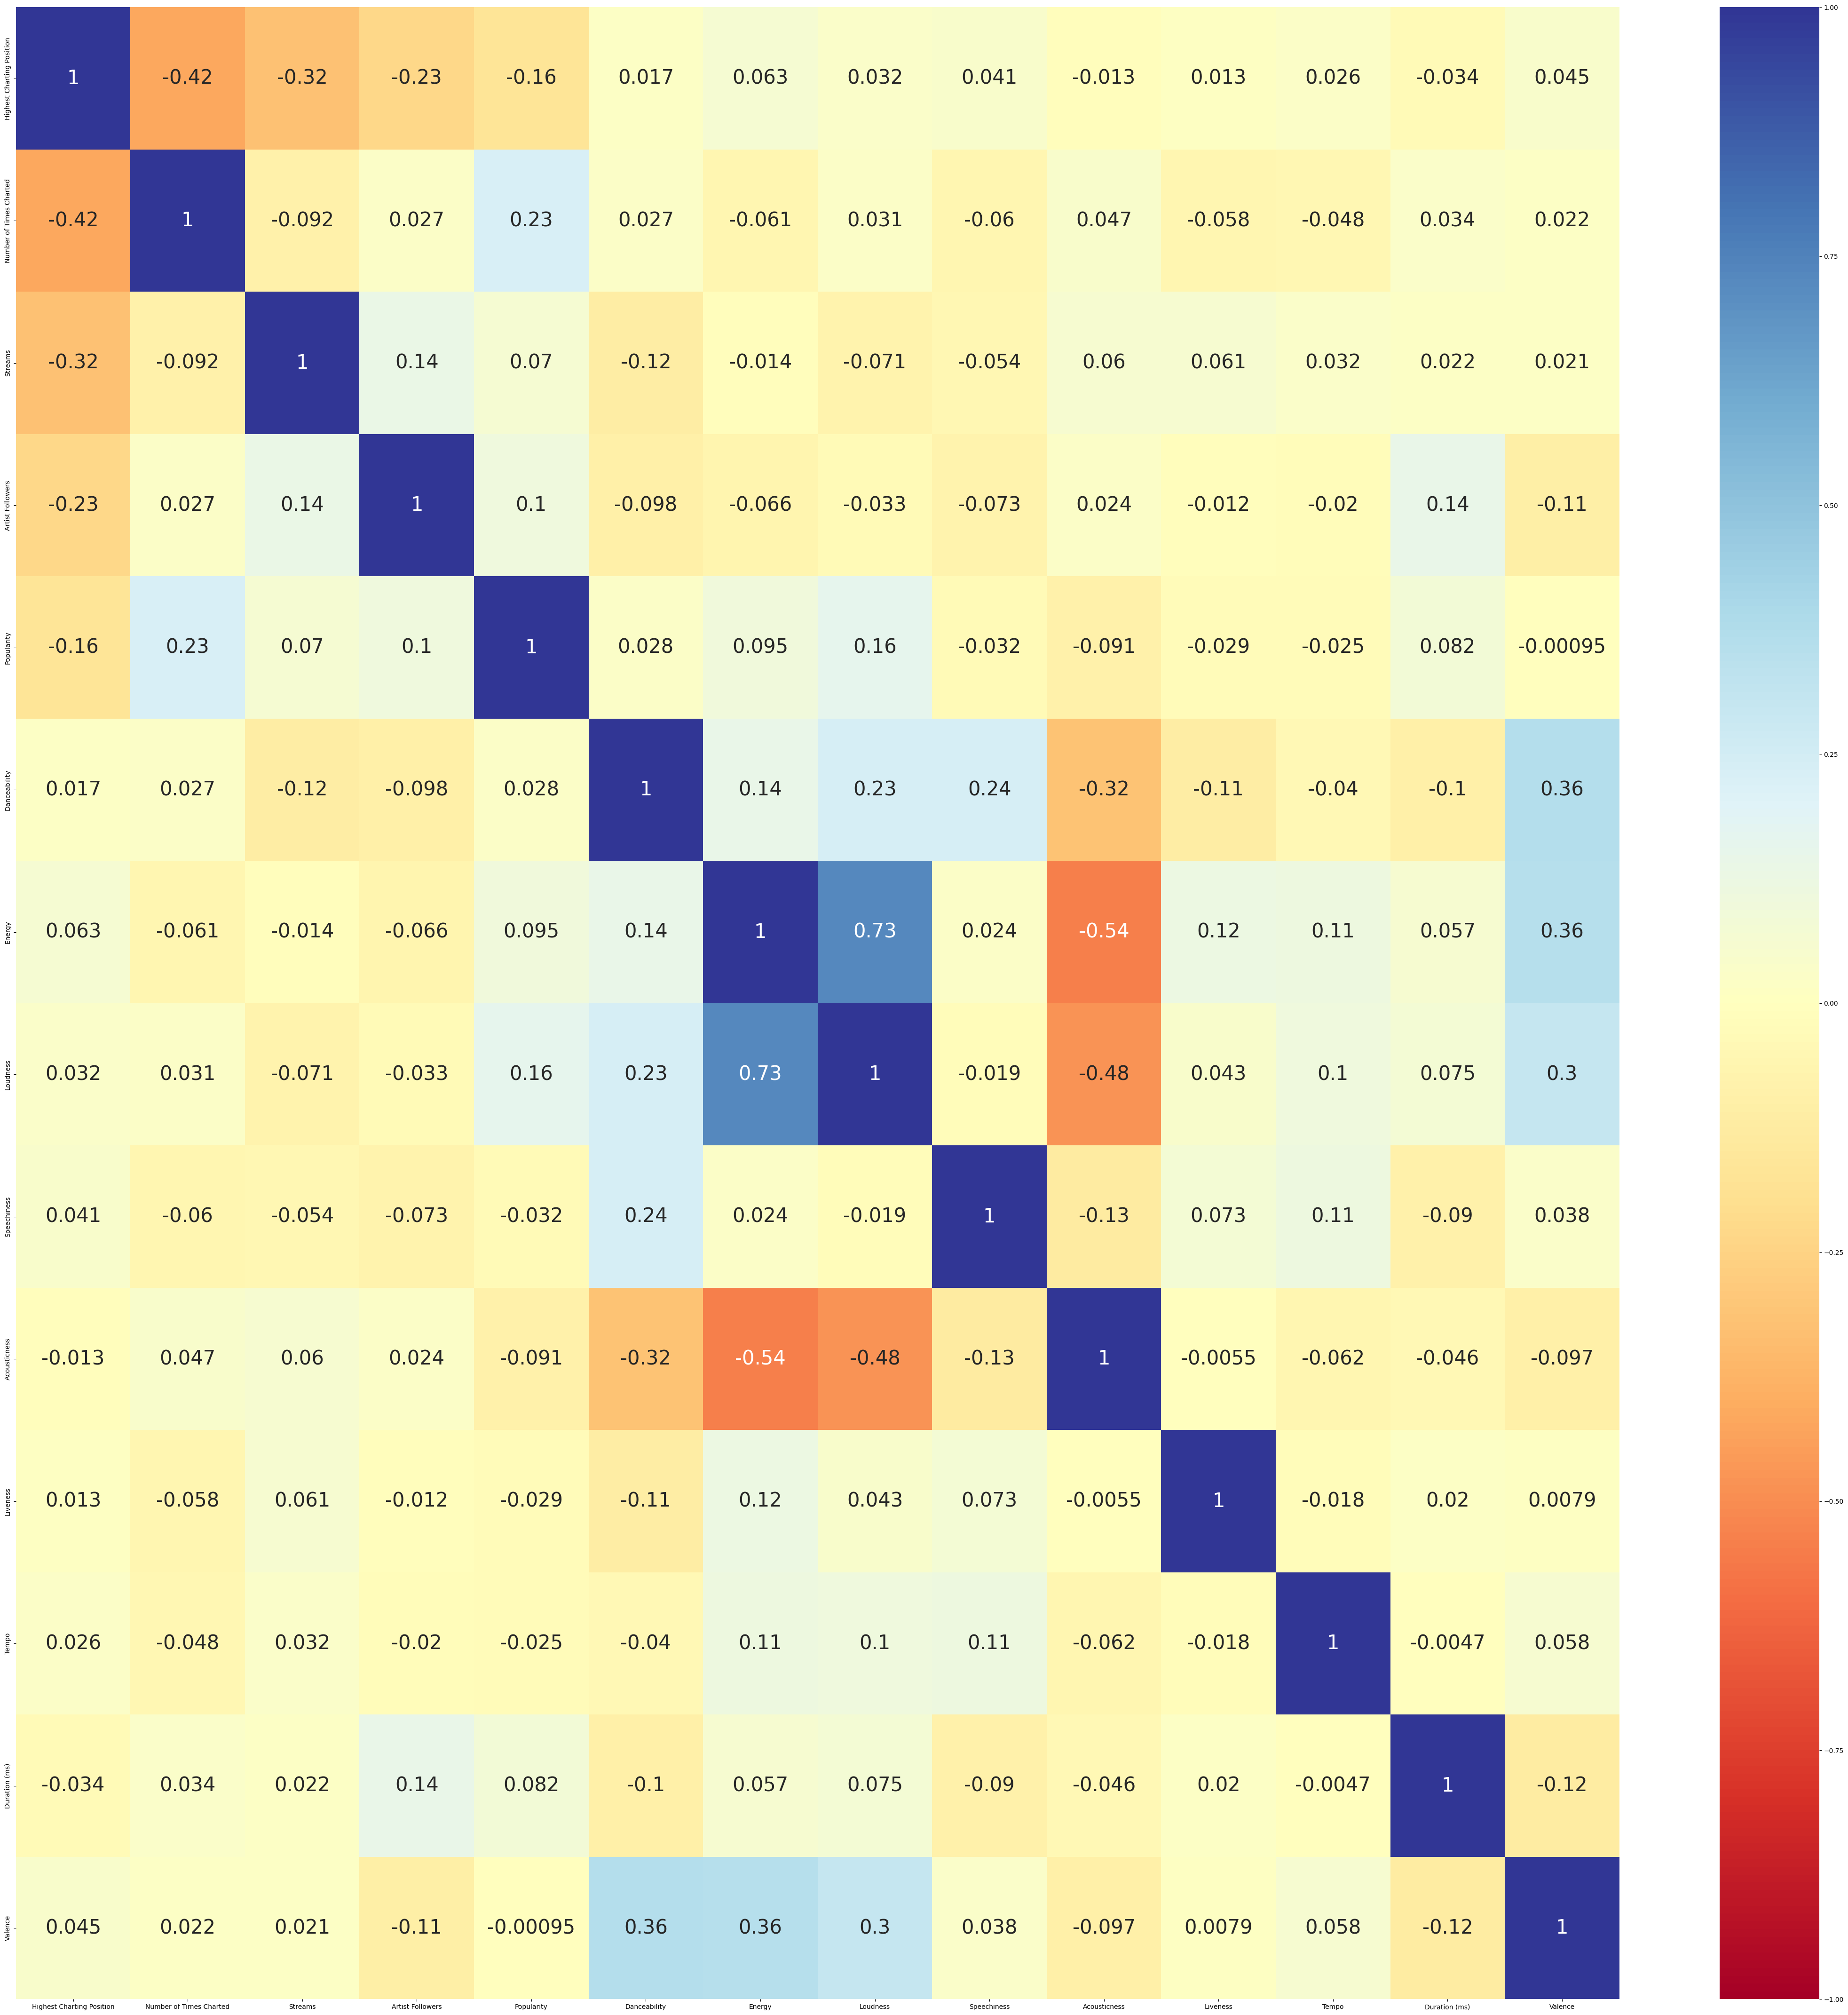

In [ ]:
#Correlation plot shows relationship between "target" and other variables.

corr = spotify.select_dtypes(include='number').corr()
plt.figure(figsize=(55,55))
sns.heatmap(corr, cmap='RdYlBu', annot=True, vmin = -1, vmax = 1, annot_kws={"fontsize": 30});

array([[<Axes: title={'center': 'Highest Charting Position'}>,
        <Axes: title={'center': 'Number of Times Charted'}>,
        <Axes: title={'center': 'Streams'}>,
        <Axes: title={'center': 'Artist Followers'}>],
       [<Axes: title={'center': 'Popularity'}>,
        <Axes: title={'center': 'Danceability'}>,
        <Axes: title={'center': 'Energy'}>,
        <Axes: title={'center': 'Loudness'}>],
       [<Axes: title={'center': 'Speechiness'}>,
        <Axes: title={'center': 'Acousticness'}>,
        <Axes: title={'center': 'Liveness'}>,
        <Axes: title={'center': 'Tempo'}>],
       [<Axes: title={'center': 'Duration (ms)'}>,
        <Axes: title={'center': 'Valence'}>, <Axes: >, <Axes: >]],
      dtype=object)

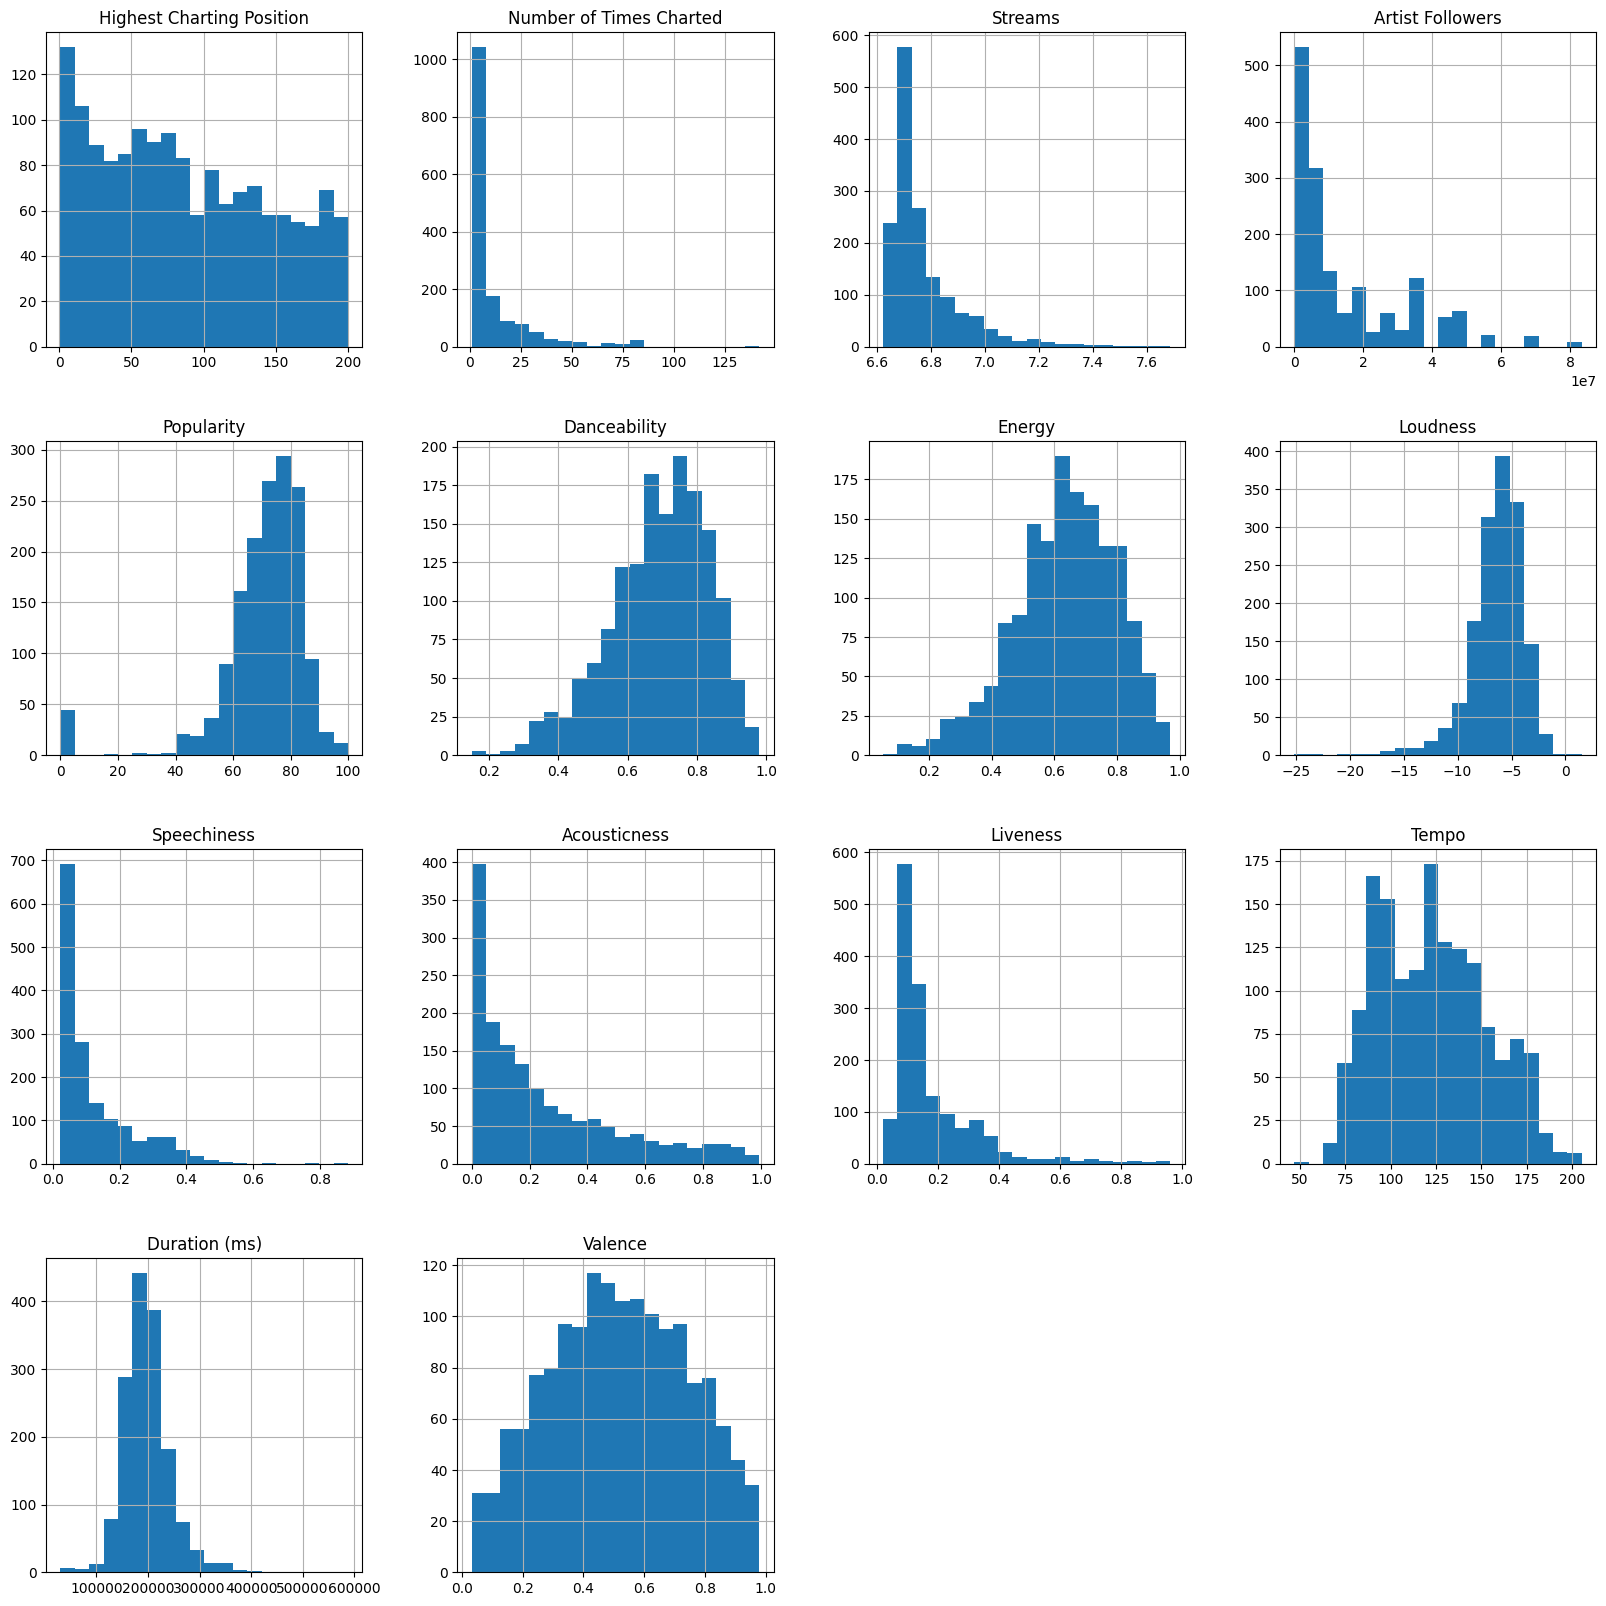

In [ ]:
# Histogram Grid shows distribution of the data across the data set variables.
spotify.hist(figsize=(20,20), bins=20)

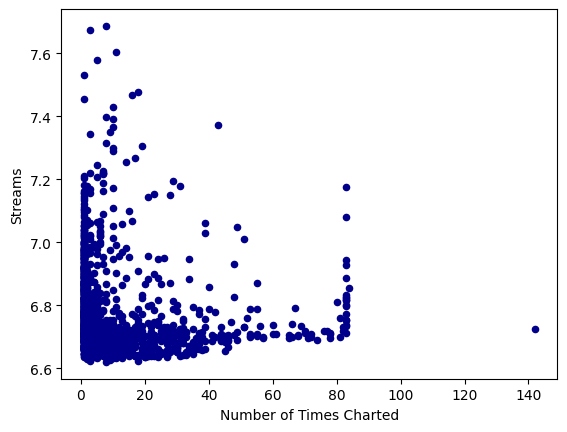

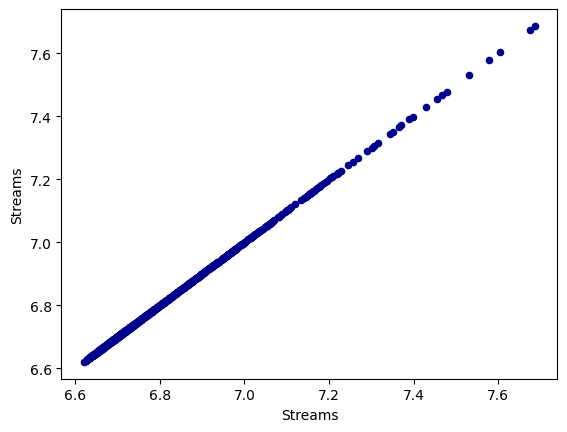

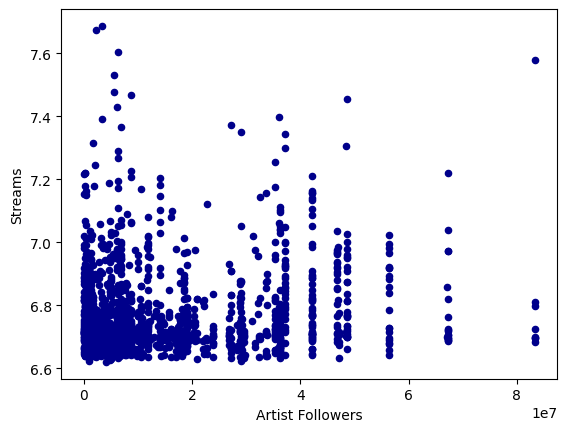

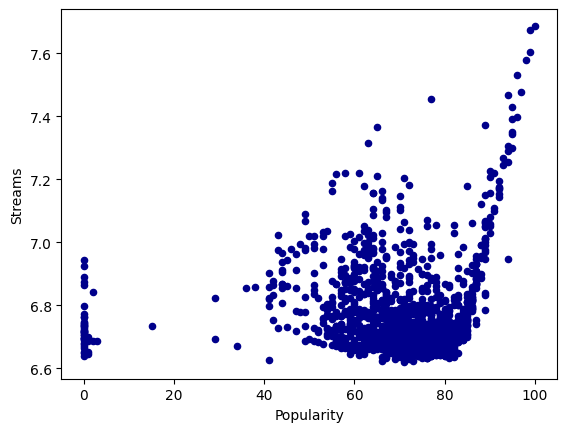

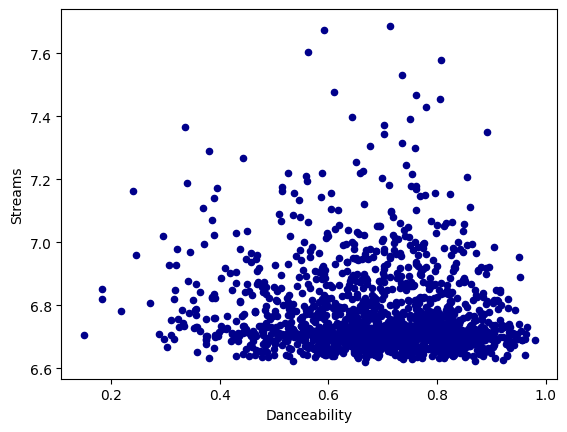

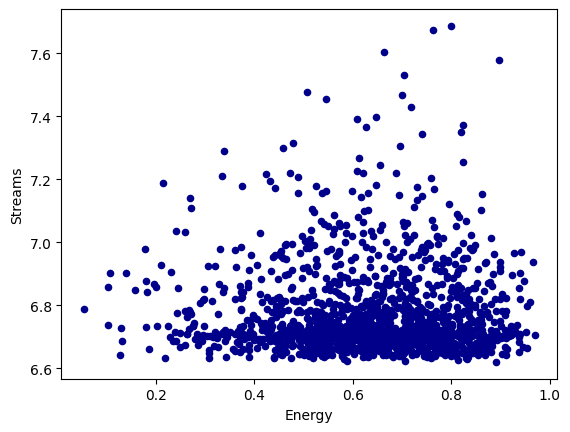

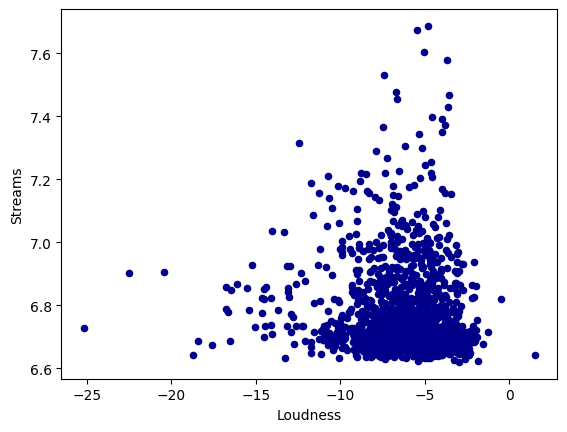

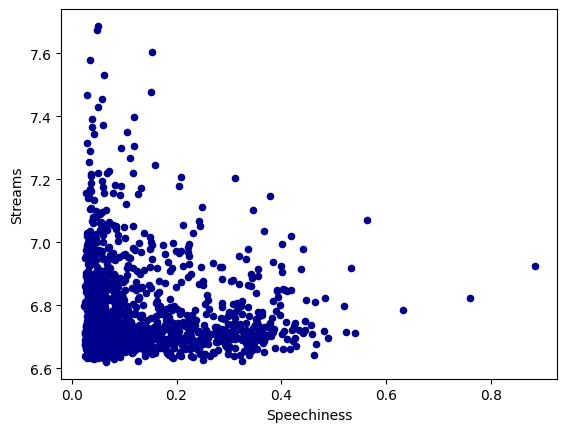

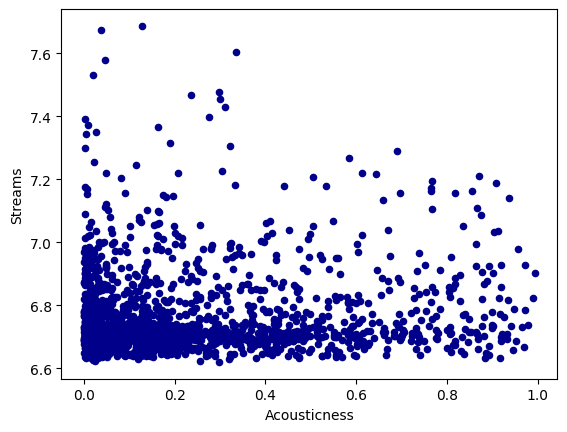

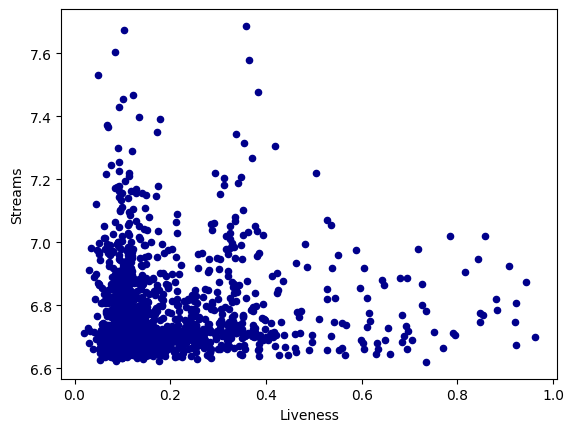

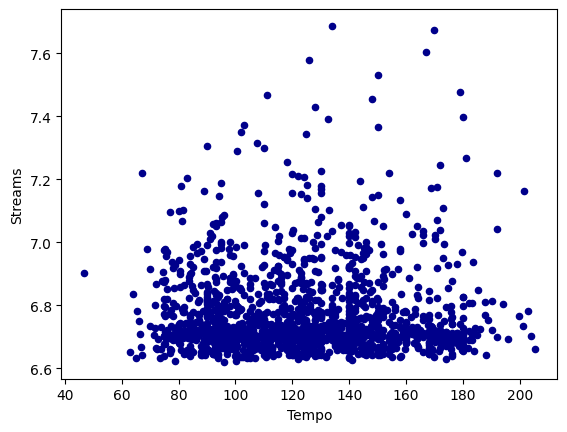

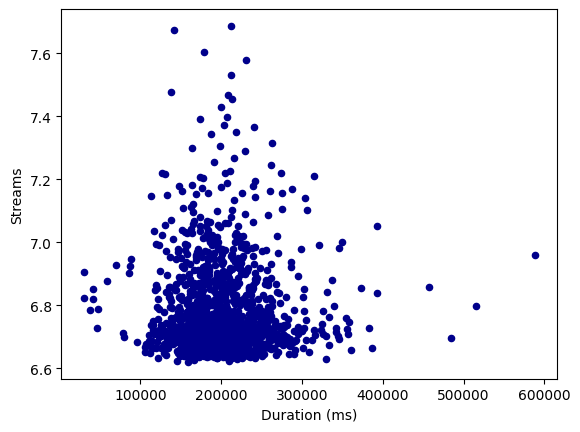

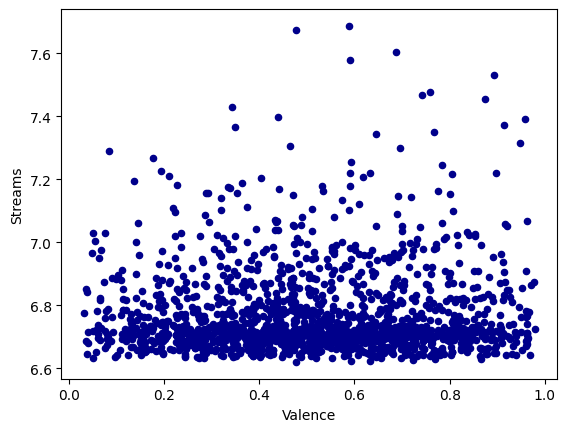

In [ ]:
# Filter values more than Absoulte value of 0.001
filter = np.abs(corr[target]) > .001
corr[filter]
selected_columns=corr[filter].index
selected_columns

# Plotting the Variables compared to the target prior to calcuations (the range excludes SalePrice)
for variable in selected_columns[1:14]:
  spotify.plot.scatter(x=variable,
                        y=target,
                        c='DarkBlue')
plt.show()

##Data Processing
>  "Crunch Numbers"

In [ ]:
y = spotify[target]
X = spotify[selected_columns].copy()
X.drop(target, axis=1, inplace=True)

In [ ]:
spotify[selected_columns].isna().sum()

,0
Highest Charting Position,0
Number of Times Charted,0
Streams,0
Artist Followers,0
Popularity,0
Danceability,0
Energy,0
Loudness,0
Speechiness,0
Acousticness,0


In [ ]:
# This list of columns was found by using Lasso Regression on all columns, and finding those with coefficent greater than 0.7
# X = X[['Artist Followers', 'Popularity', 'Energy', 'Acousticness', 'Liveness', 'Tempo', 'Duration (ms)', 'Valence']]
X
# This list of columns was found by using Lasso Regression on all columns, and finding those with abs val coefficent greater than 0.3
# X = X[['Highest Charting Position', 'Number of Times Charted', 'Popularity']]

#This is a final list of columns using Lasso, and ABS Val coefficient greater than 0.1
X = X[['Highest Charting Position', 'Number of Times Charted', 'Popularity', 'Danceability', 'Loudness', 'Speechiness', 'Tempo', 'Valence']]
X.head()

,Highest Charting Position,Number of Times Charted,Popularity,Danceability,Loudness,Speechiness,Tempo,Valence
0,1,8,100,0.714,-4.808,0.0504,134.002,0.589
1,2,3,99,0.591,-5.484,0.0483,169.928,0.478
2,1,11,99,0.563,-5.044,0.1540,166.928,0.688
3,3,5,98,0.808,-3.712,0.0348,126.026,0.591
4,5,1,96,0.736,-7.409,0.0615,149.995,0.894


In [ ]:
#Scale the data off of Sales, and split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5)

#Scaling, normalize the features
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
np.isnan(X).sum()

,0
Highest Charting Position,0
Number of Times Charted,0
Popularity,0
Danceability,0
Loudness,0
Speechiness,0
Tempo,0
Valence,0


In [ ]:
# Fit a linear model using Sklearn
model = LinearRegression()
my_fit_lr = model.fit(X_train, y_train)

In [ ]:
# Create a data frame with the results from the linear regression models
model_results = pd.DataFrame()
model_results['Predictor'] = X.columns
model_results['Linear'] = my_fit_lr.coef_
model_results.sort_values(by=['Linear'],inplace=True, ascending=False)
model_results

,Predictor,Linear
7,Valence,0.065539
2,Popularity,0.064997
6,Tempo,0.042222
5,Speechiness,-0.032862
3,Danceability,-0.073608
4,Loudness,-0.104454
0,Highest Charting Position,-0.188995
1,Number of Times Charted,-0.192310


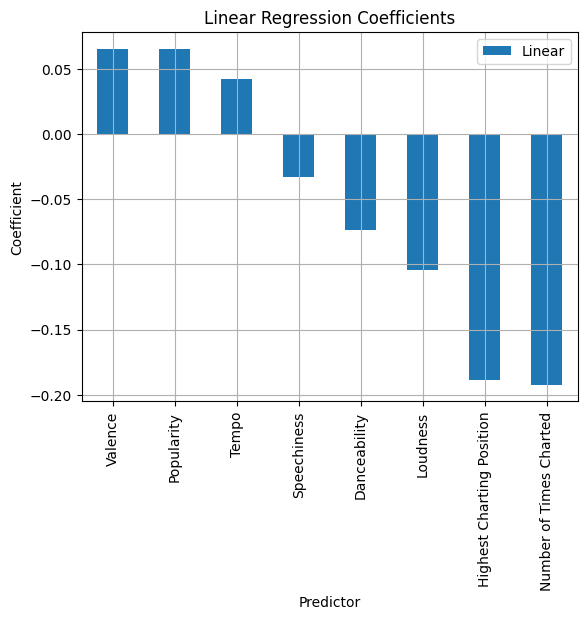

In [ ]:
# We can even plot the coefficients if we want to!
model_results.plot(x = 'Predictor', y = 'Linear', kind = 'bar', ylabel='Coefficient', title='Linear Regression Coefficients')
plt.grid()

In [ ]:
# Perform CV
n = 500
results = np.zeros(n)
for idx in range(n):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25)
  model = LinearRegression()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  results[idx] = np.sqrt(mean_squared_error(y_test,y_pred))
print(f"CV RMSE: {results.mean().round(2)}")
print(f"Number of Predictors: {len(X.columns)}")

CV RMSE: 0.12
Number of Predictors: 8


(-4.0, 4.0)

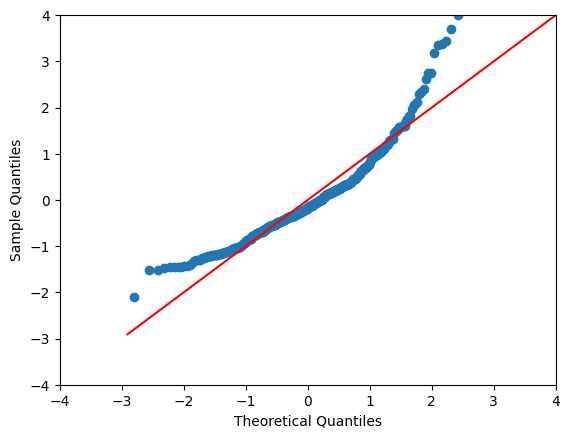

In [ ]:
# QQ Plot of Linear Regression - Residuals are normally distributed
res = y_test - y_pred
sm.qqplot(res, fit=True, line="45") ;
plt.xlim(-4, 4)
plt.ylim(-4, 4)

In [ ]:
results.mean().round(2) / (spotify[target].max() - spotify[target].min())


np.float64(0.11255283493651377)

In [ ]:
results.mean().round(2) / spotify[target].median()

np.float64(0.017852515990946737)

<Axes: ylabel='Density'>

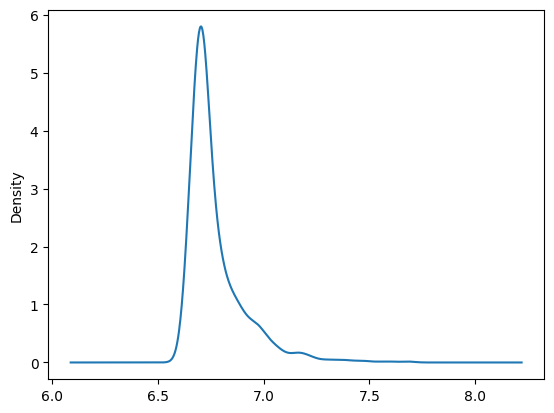

In [ ]:
(spotify[target]).plot.kde()

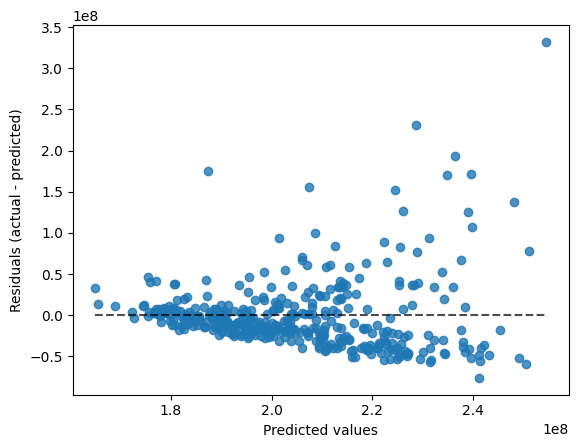

In [ ]:
display=sklearn.metrics.PredictionErrorDisplay(y_true=y_test**10, y_pred=y_pred**10)
display.plot()
plt.show()

In [ ]:
# Specify values of alpha we want to try
alph = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 10, 20, 30, 50]

# Create empty list to hold results
results_alpha = []

for i in alph:
  # Train the model
  my_fit_rr = Ridge(alpha = i) # Looping through alpha

  scalar = StandardScaler()

  pipeline = Pipeline([('transformer', scalar), ('estimator', my_fit_rr)])

  # Calculate CV RMSE
  results = cross_val_score(
      pipeline,
      X,
      y,
      scoring='neg_root_mean_squared_error',
      cv = 10
      )
  rmse = abs(results.mean())
  results_alpha.append(rmse)

results_df = pd.DataFrame({'Alpha': alph, 'RMSE': results_alpha})
print(results_df.sort_values(by=['RMSE']))

           Alpha      RMSE
15  5.000000e+01  0.125536
14  3.000000e+01  0.125706
13  2.000000e+01  0.125798
12  1.000000e+01  0.125896
11  5.000000e+00  0.125947
10  4.000000e+00  0.125957
9   3.000000e+00  0.125968
8   2.000000e+00  0.125978
7   1.000000e+00  0.125989
6   1.000000e-01  0.125998
5   1.000000e-02  0.125999
4   1.000000e-03  0.125999
3   1.000000e-04  0.125999
2   1.000000e-08  0.125999
1   1.000000e-10  0.125999
0   1.000000e-15  0.125999


In [ ]:
#Trying Min - Max Scaler vs Standard Scaler
# Specify values of alpha we want to try
alph = [1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 4, 5, 10, 20, 30, 50]

# Create empty list to hold results
results_alpha = []

for i in alph:
  # Train the model
  my_fit_rr = Ridge(alpha = i) # Looping through alpha

  scalar = MinMaxScaler()

  pipeline = Pipeline([('transformer', scalar), ('estimator', my_fit_rr)])

  # Calculate CV RMSE
  results = cross_val_score(
      pipeline,
      X,
      y,
      scoring='neg_root_mean_squared_error',
      cv = 10
      )
  rmse = abs(results.mean())
  results_alpha.append(rmse)

results_df = pd.DataFrame({'Alpha': alph, 'RMSE': results_alpha})
print(results_df.sort_values(by=['RMSE']))

           Alpha      RMSE
13  2.000000e+01  0.124884
14  3.000000e+01  0.124919
12  1.000000e+01  0.124944
15  5.000000e+01  0.125031
11  5.000000e+00  0.125159
10  4.000000e+00  0.125248
9   3.000000e+00  0.125364
8   2.000000e+00  0.125517
7   1.000000e+00  0.125722
6   1.000000e-01  0.125968
5   1.000000e-02  0.125996
4   1.000000e-03  0.125999
3   1.000000e-04  0.125999
2   1.000000e-08  0.125999
1   1.000000e-10  0.125999
0   1.000000e-15  0.125999


In [ ]:
# %%capture --no-stdout
X_lasso = X
y_lasso = y

# Specify values of alpha we want to try
alph = [50, 75, 100, 200, 300, ]

# Create empty list to hold results
results_alpha = []

for i in alph:
  # Calculate CV RMSE
  n = 200
  results = np.zeros(n)

  for idx in range(n):
    # Create the model
    my_fit_lasso = Lasso(alpha = i, tol = .01, max_iter=10_000); # Looping through alpha

    # Train, test split
    X_train, X_test, y_train, y_test = train_test_split(X_lasso, y_lasso, test_size=0.25)

    # Standard scale only training features
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)

    # Scale testing features
    X_test = scaler.transform(X_test)

    # Fit regression
    my_fit_lasso.fit(X_train, y_train)

    # Predict
    y_predl = my_fit_lasso.predict(X_test)

    # Calculate and record performance metric
    results[idx] = np.sqrt(mean_squared_error(y_test,y_predl))

  results_alpha.append(results.mean())

results_df = pd.DataFrame({'Alpha': alph, 'RMSE': results_alpha})


In [ ]:
my_fit_lasso.coef_

array([-0., -0.,  0., -0., -0., -0.,  0.,  0.])

In [ ]:
# Used this code to find desirable features to use for the next phase.
# abslasso = np.abs(my_fit_lasso.coef_)
# mask = (abslasso - abslasso.min())/(abslasso.max() - abslasso.min()) > 0.1
# X.columns[mask]

In [ ]:
# (abslasso - abslasso.min())/(abslasso.max() - abslasso.min())

In [ ]:
results_df

,Alpha,RMSE
0,50,0.137904
1,75,0.137321
2,100,0.138783
3,200,0.136802
4,300,0.137915


(-4.0, 4.0)

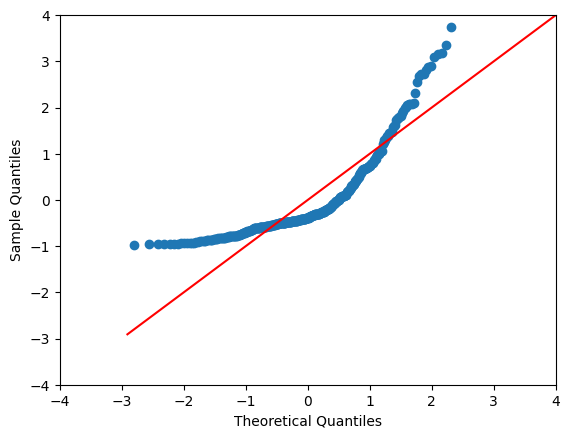

In [ ]:
# QQ Plot of Lasso Regression - Residuals are normally distributed
res = y_test - y_predl
sm.qqplot(res, fit=True, line="45") ;
plt.xlim(-4, 4)
plt.ylim(-4, 4)

In [ ]:
numLoops = 500

rms_error = np.zeros(numLoops)

for idx in range(0,numLoops):
  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
  model = DecisionTreeRegressor(max_depth=3)         # Arbitrarily choosing max_depth of 3
  model.fit(X_train,y_train)
  y_predt = model.predict(X_test)
  rms_error[idx] = np.sqrt(mean_squared_error(y_test, y_predt))

print(f"CV RMSE: {rms_error.mean().round(2)}")

CV RMSE: 0.09


## Data Visualization
> "Lets Plot"

(-4.0, 4.0)

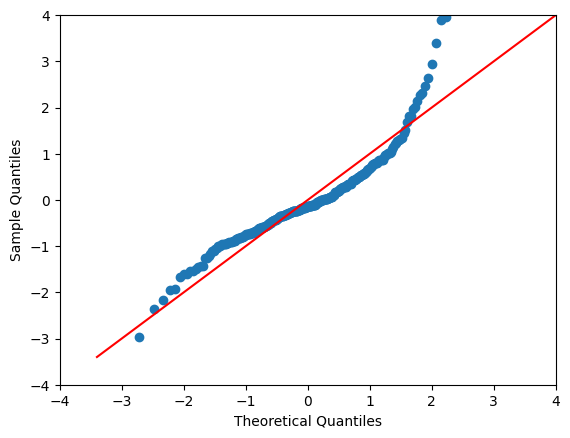

In [ ]:
# QQ Plot of Decision Tree - Residuals are normally distributed
res = y_test - y_predt
sm.qqplot(res, fit=True, line="45") ;
plt.xlim(-4, 4)
plt.ylim(-4, 4)

In [ ]:
rms_error.mean().round(2) / spotify[target].mean()


np.float64(0.013288705939242425)

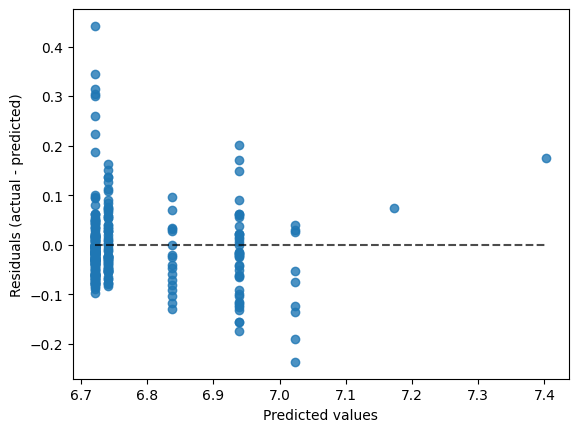

In [ ]:
display=sklearn.metrics.PredictionErrorDisplay(y_true=y_test, y_pred=y_predt)
display.plot()
plt.show()

In [ ]:
np.unique(y)

array([6.62076912, 6.62470968, 6.62512727, ..., 7.60382138, 7.67439004,
       7.68693507])

## Communication of Results
> "What did we find?"


Using **'Streams'** as target, the features were limited based on lasso regression results.

(Lasso regression filters data by automatically selecting the most important features by shrinking the coefficients of less important features)

The features selected using Lasso (Absolute Value of coefficient > 0.1) were the following:

* Valence
*	Popularity
*	Tempo
*	Speechiness
*	Danceability
*	Loudness
*	Highest Charting Position
* Number of Times Charted

Then I used logorithmic transform on 'Streams' values.

It was recommended, due to the large outliers in stream values, log transform may be needed.

Results were recalculated:

Linear Regression provided CV RMSE: 0.12

Ridge Regression provided RMSE: 0.12

Lasso Regression provided RMSE: 0.14

Decision Tree CV RMSE: 0.09

QQ Plot showed heavy tails.